In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import sys
sys.path.append('../utils')
sys.path.append('../dFC')
import widefield_utils
import connectivity_measures

from skimage.measure import block_reduce
from sklearn.decomposition import FastICA

import datetime

In [2]:
import numpy as np
import os

def load_registered_sample(base_directory,registered_directory,start,end):
    corrected_svt = np.load(os.path.join(base_directory, "Corrected_SVT.npy"))
    u = np.load(os.path.join(registered_directory, "Registered_U.npy"))
    delta_f_sample = np.dot(u, corrected_svt[:, start:end])
    return delta_f_sample

def normalize_periodograms(S):
    #try to normalize each signal dividing by its maximum
    max_values = np.max(S, axis=1)
    # divide each row by its maximum value
    S = S / max_values.reshape(-1, 1)
    return S

def compute_distance(i,j,H,W,loc):
    r_i, c_i = np.unravel_index(loc[0][i], (H,W))
    r_j, c_j = np.unravel_index(loc[0][j], (H,W))
    return np.sqrt((r_i-r_j)^2+(c_i-c_j)^2)

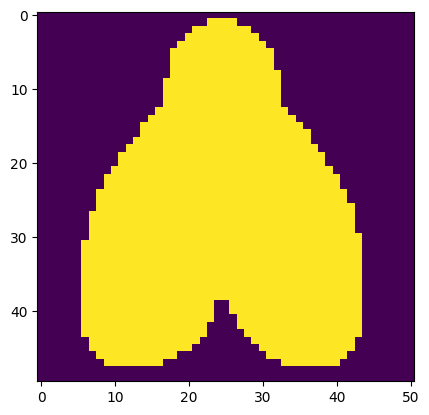

In [3]:
mask_dict = np.load(r"/home/k21208334/calcium_analyses/data/Tight_Mask_Dict.npy", allow_pickle=True)[()]

array_indicies = np.array(mask_dict['indicies'])

image = np.ravel(np.zeros((300,304)))
image[array_indicies]=1
plt.imshow(np.reshape(image,(300,304)))

downsampled_tight_mask = block_reduce(np.reshape(image,(300,304)), block_size=(6,6), func=np.min) 
plt.imshow(downsampled_tight_mask)

final_mask = downsampled_tight_mask>0

In [4]:
H = np.shape(final_mask)[0]
W = np.shape(final_mask)[1]

h=300
w=304
window_size = 140

start = 0
end = 25000
connectivity_thr = 0.2

good_indices = np.ravel(final_mask)


In [ ]:
names = ["NXAK22.1A","NXAK14.1A","NXAK7.1B","NXAK4.1B","NRXN78.1D","NRXN78.1A"]
names_knock = ["NXAK24.1C","NXAK20.1B","NXAK16.1B","NXAK10.1A","NXAK4.1A","NRXN71.2A"]

concatenated_signals = np.empty((np.sum(good_indices),0))
good_indices = np.ravel(final_mask)

now = datetime.datetime.now()
print("starting:", now.time())

for name in names+names_knock: # first one already done

    print("\n loading: ",name)
    walking = np.load("/home/k21208334/calcium_analyses/data/walking/"+name+".npy")
    base_directory = r"/home/k21208334/calcium_analyses/data/" + name + "/"
    registered_directory = r"/home/k21208334/calcium_analyses/data/registration_data/" + name + "/"
    sample = load_registered_sample(base_directory,registered_directory,start,end)
    coarse_sample = block_reduce(sample, block_size=(6,6,1), func=np.mean) 
    #  connectivity: flatten data
    all_signals = np.reshape(coarse_sample,(H*W,end))
    # remove zero signals based on mask!
    signals = all_signals[good_indices,:]
    concatenated_signals = np.hstack((concatenated_signals,signals))

starting: 11:12:37.864095

 loading:  NXAK22.1A


In [19]:
now = datetime.datetime.now()
print("end loading:", now.time())

n_comp = 15
model = FastICA(n_components = n_comp,whiten='unit-variance')
S = model.fit_transform(np.transpose(concatenated_signals)) 

end loading: 15:28:02.403037


In [21]:
components = model.mixing_
np.save('/home/k21208334/calcium_analyses/data/ICA/signals_n=' + str(n_comp) + '.npy',S)
np.save('/home/k21208334/calcium_analyses/data/ICA/components_n=' + str(n_comp) + '.npy',components)

In [ ]:
# spatial ica: ica on transpose
now = datetime.datetime.now()
print("end loading:", now.time())

n_comp = 15
model = FastICA(n_components = n_comp,whiten='unit-variance')
S = model.fit_transform(concatenated_signals) 

In [ ]:
components = model.mixing_
np.save('/home/k21208334/calcium_analyses/data/ICA/ICA_T_signals_n=' + str(n_comp) + '.npy',S)
np.save('/home/k21208334/calcium_analyses/data/ICA/ICA_T_components_n=' + str(n_comp) + '.npy',components)

# do a plot of the components found

In [22]:
def plot_centrality(degree,H,W,good_indices,mi,ma):
    degree_all = np.zeros(H*W)
    degree_all[good_indices] = degree
    fig,ax = plt.subplots()
    ax.imshow(np.reshape(degree_all,(H,W)),vmin=mi,vmax=ma)
    return fig

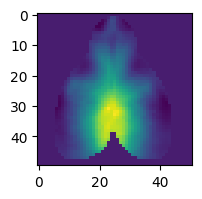

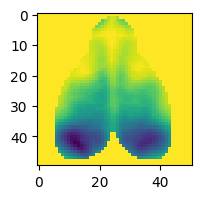

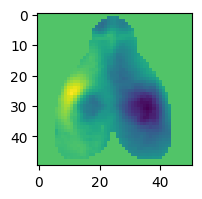

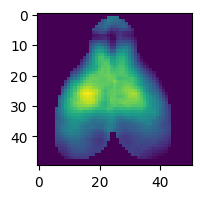

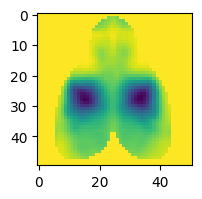

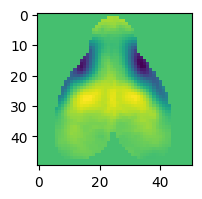

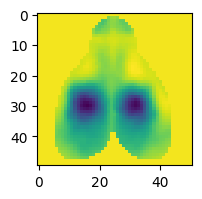

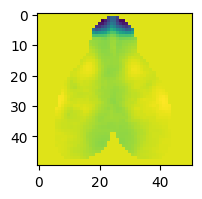

In [23]:
for i in range(n_comp):
    fig = plot_centrality(components[:,i],H,W,good_indices,components[:,i].min(),components[:,i].max())
    fig.set_size_inches(2,2)